In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)

In [2]:
df = pd.read_csv("Data/BAJAJFINSV.csv")
df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514


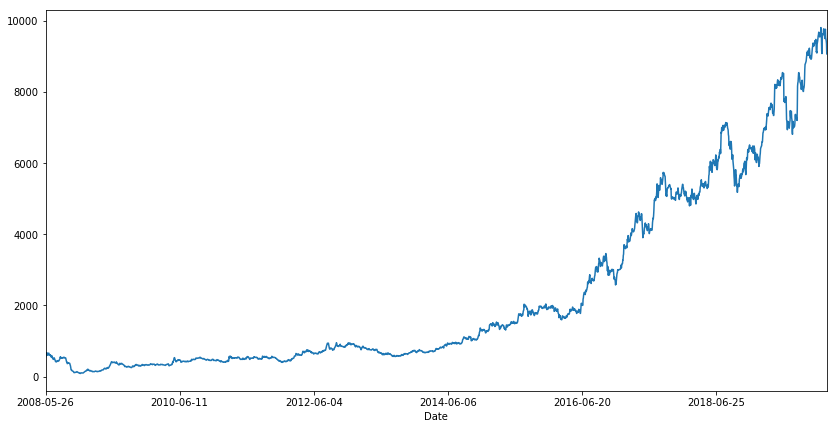

In [3]:
df.VWAP.plot(figsize=(14, 7))

In [4]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[str(feature) +"_mean_lag"+ str(window1)] = df_mean_3d[feature]
    df[str(feature)+"_mean_lag"+str(window2)] = df_mean_7d[feature]
    df[str(feature)+"_mean_lag"+str(window3)] = df_mean_30d[feature]
    
    df[str(feature)+"_std_lag"+str(window1)] = df_std_3d[feature]
    df[str(feature)+"_std_lag"+str(window2)] = df_std_7d[feature]
    df[str(feature)+"_std_lag"+str(window3)] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)
# Or mode

df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,...,4.535497e+13,1.742106e+13,2.239346e+13,3.049945e+13,12376.533203,12354.592773,12251.893555,4376.82373,5480.245117,7166.581543
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,...,1.726368e+14,1.742106e+13,2.239346e+13,3.049945e+13,12376.533203,12354.592773,12251.893555,4376.82373,5480.245117,7166.581543
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,...,2.107369e+14,5.388164e+13,5.388164e+13,5.388164e+13,12376.533203,12354.592773,12251.893555,4376.82373,5480.245117,7166.581543
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,...,2.350756e+14,5.682195e+13,5.682195e+13,5.682195e+13,12376.533203,12354.592773,12251.893555,4376.82373,5480.245117,7166.581543
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,...,2.508797e+14,2.541759e+13,5.613884e+13,5.613884e+13,12376.533203,12354.592773,12251.893555,4376.82373,5480.245117,7166.581543


In [5]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,...,12376.533203,12354.592773,12251.893555,4376.82373,5480.245117,7166.581543,5,22,26,0
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,...,12376.533203,12354.592773,12251.893555,4376.82373,5480.245117,7166.581543,5,22,27,1
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,...,12376.533203,12354.592773,12251.893555,4376.82373,5480.245117,7166.581543,5,22,28,2
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,...,12376.533203,12354.592773,12251.893555,4376.82373,5480.245117,7166.581543,5,22,29,3
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,...,12376.533203,12354.592773,12251.893555,4376.82373,5480.245117,7166.581543,5,22,30,4


In [6]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogen = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

In [7]:
df_train

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.10,509.10,548.85,...,12376.533203,12354.592773,12251.893555,4376.823730,5480.245117,7166.581543,5,22,26,0
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.00,554.65,572.15,...,12376.533203,12354.592773,12251.893555,4376.823730,5480.245117,7166.581543,5,22,27,1
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.00,640.95,618.37,...,12376.533203,12354.592773,12251.893555,4376.823730,5480.245117,7166.581543,5,22,28,2
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.50,632.40,659.60,...,12376.533203,12354.592773,12251.893555,4376.823730,5480.245117,7166.581543,5,22,29,3
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.00,644.00,636.41,...,12376.533203,12354.592773,12251.893555,4376.823730,5480.245117,7166.581543,5,22,30,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,BAJAJFINSV,EQ,6360.10,6360.75,6393.95,6260.0,6280.00,6274.45,6308.27,...,37744.667969,29538.572266,25242.166016,18024.671875,13629.165039,8730.109375,12,52,24,0
2018-12-26,2018-12-26,BAJAJFINSV,EQ,6274.45,6272.00,6465.00,6150.0,6465.00,6439.05,6322.02,...,24502.000000,27488.285156,25015.767578,10393.599609,14417.124023,8863.626953,12,52,26,2
2018-12-27,2018-12-27,BAJAJFINSV,EQ,6439.05,6500.00,6550.00,6350.0,6381.00,6405.05,6450.86,...,26611.000000,28028.000000,25208.132812,9795.016602,14292.675781,8836.926758,12,52,27,3


## Models

### Arimax

In [8]:
model = auto_arima(df_train.VWAP, 
                   exogenous=df_train[exogen], 
                   trace=True, error_action="ignore", 
                   suppress_warnings=True)

model.fit(df_train.VWAP, 
          exogenous = df_train[exogen])

forecast = model.predict(n_periods=len(df_valid), 
                         exogenous=df_valid[exogen])

df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=28900.706, BIC=29135.650, Time=14.353 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=29449.933, BIC=29661.382, Time=10.662 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=28954.300, BIC=29171.623, Time=10.942 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=29242.996, BIC=29460.319, Time=12.021 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=47505.973, BIC=47711.549, Time=10.380 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=28891.900, BIC=29120.970, Time=13.893 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=28842.845, BIC=29066.041, Time=13.514 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=28846.562, BIC=29075.632, Time=13.899 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=28971.355, BIC=29194.552, Time=12.338 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=Tru

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



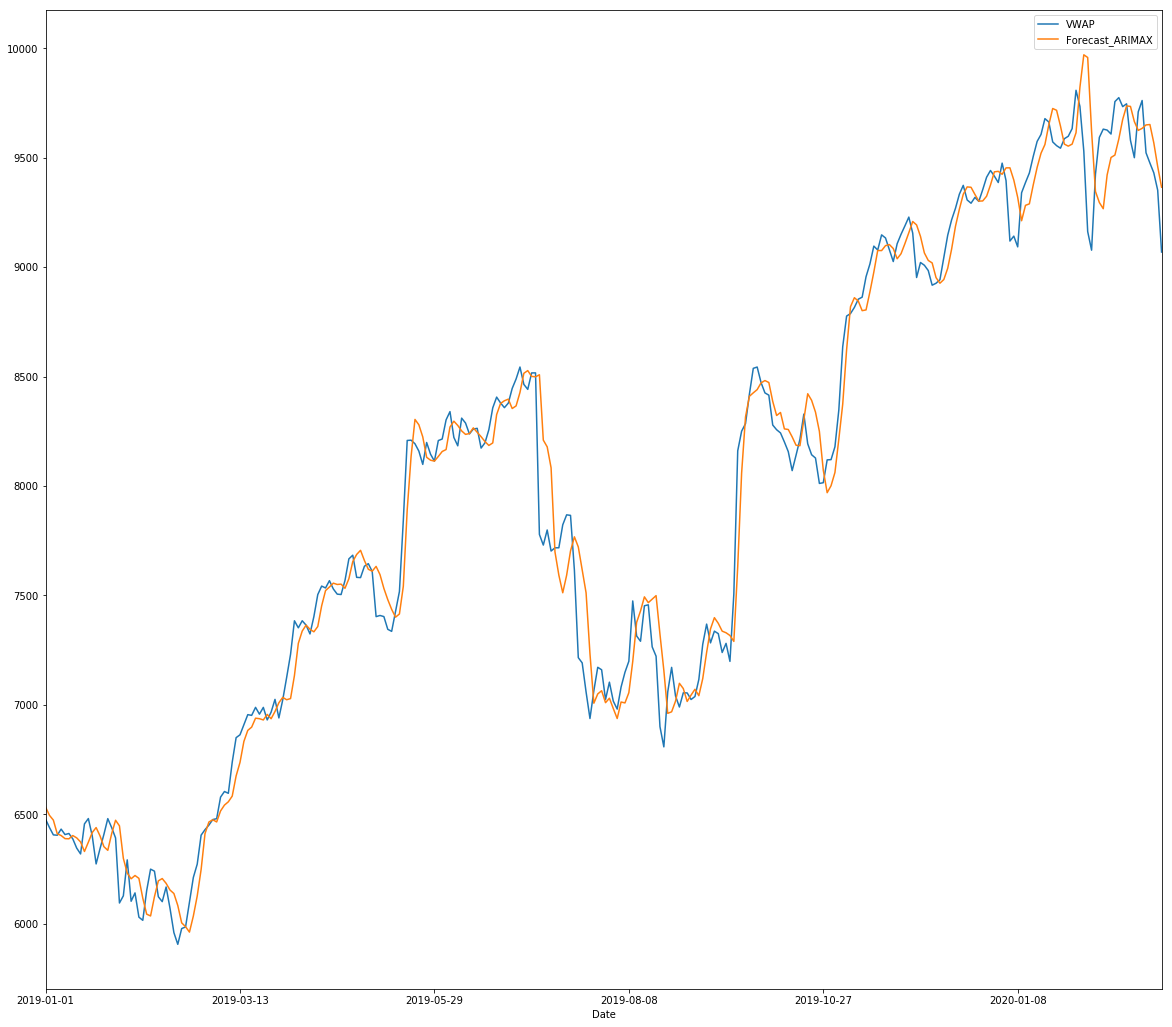

In [9]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(20, 18))

In [21]:
arim = [np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)),  
        mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)]
print("RMSE, ARIMAX:", Arim[0])
print("\nMAE, ARIMAX:", Arim[1])

RMSE, ARIMAX: 161.2809200204543

MAE, ARIMAX: 114.08049516167583


### Prophet

In [16]:
model_fbp = Prophet()
for feature in exogen:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogen].rename(columns={"Date": "ds", 
                                                                  "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogen].rename(columns={"Date": "ds"}))

df_valid["Forecast_Prophet"] = forecast.yhat.values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



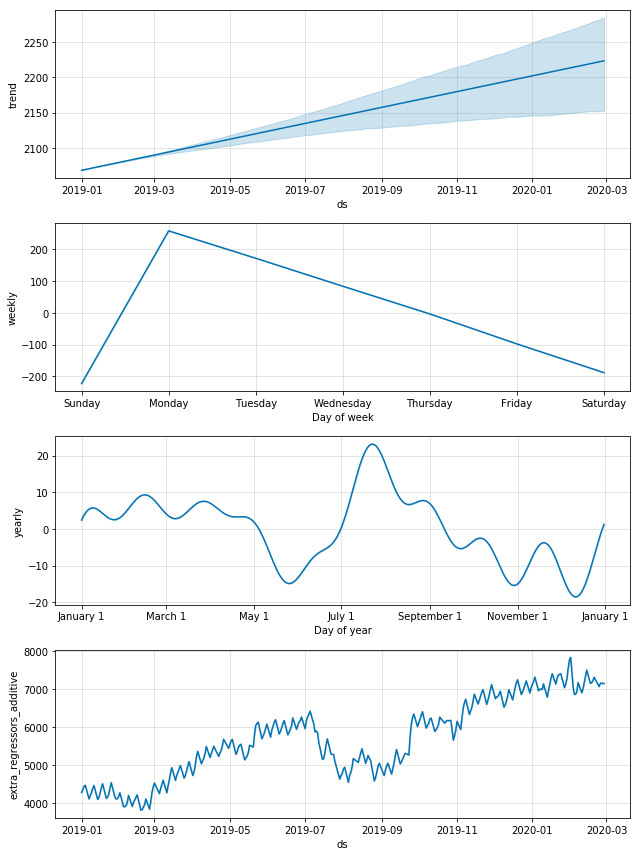

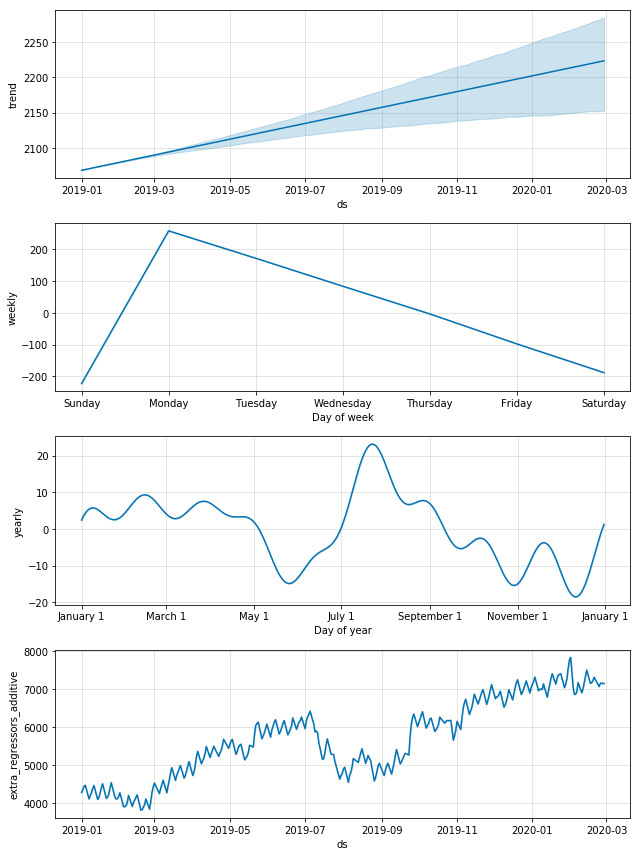

In [17]:
model_fbp.plot_components(forecast)

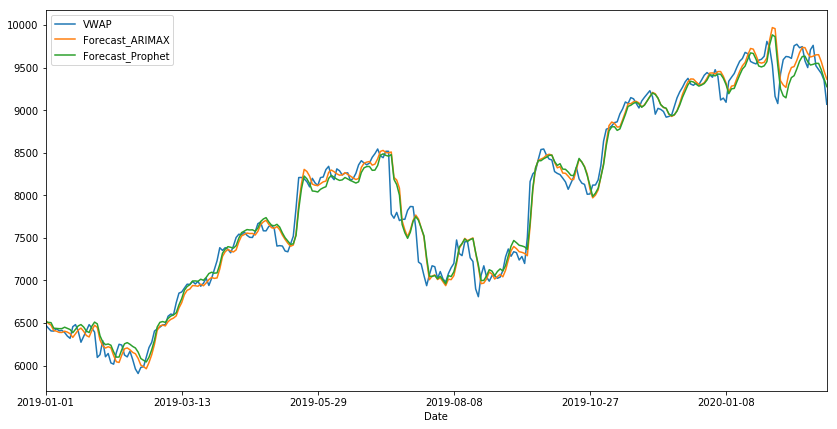

In [18]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [22]:
prophet = [np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)), 
          mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet)]
print("RMSE, ARIMAX:", arim[0])
print("RMSE,Prophet:", prophet[0])
print("\nMAE, Auto ARIMAX:", arim[1])
print("MAE, Prophet:", prophet[1])

RMSE, ARIMAX: 161.2809200204543
RMSE,Prophet: 165.56819953731272

MAE, Auto ARIMAX: 114.08049516167583
MAE, Prophet: 120.7215598724483


### Light GBM

In [24]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogen], 
                     label=df_train.VWAP.values)

dvalid = lgb.Dataset(df_valid[exogen])

model_lgb = lgb.train(params, 
                      train_set = dtrain)

forecast = model_lgb.predict(df_valid[exogen])

df_valid["Forecast_LightGBM"] = forecast

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



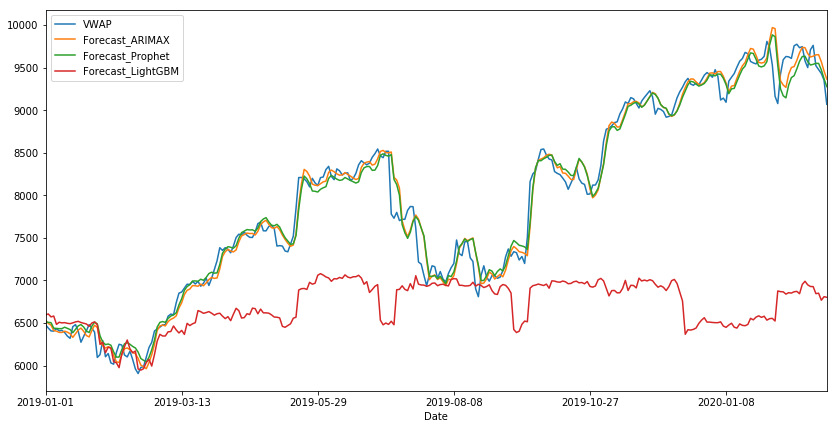

In [25]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

In [26]:
lgbm = [np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_LightGBM)),
       mean_absolute_error(df_valid.VWAP, df_valid.Forecast_LightGBM)]

## Comparision

The below made table is adapted from https://www.tablesgenerator.com/markdown_tables

|   	|   RMSE|   MAE|
|---	|---	|---	|
|   Arimax|   161.2809200204543|  114.08049516167583|
|   Prophet|   165.56819953731272|   120.7215598724483|
|   GBM|   1579.7595561305006|   1236.2503124562052|